
# Vision Transformers

이 튜토리얼에서는 최근의 새로운 트렌드를 자세히 살펴보겠습니다: 컴퓨터 비전을 위한 트랜스포머입니다. [Alexey Dosovitskiy et al](https://openreview.net/pdf?id=YicbFdNTTy)가 다양한 이미지 인식 벤치마크에 트랜스포머를 성공적으로 적용한 이후, CNN이 더 이상 컴퓨터 비전을 위한 최적의 아키텍처가 아닐 수 있음을 보여주는 후속 연구들이 엄청나게 많이 진행되었습니다.
그렇다면 비전 트랜스포머는 정확히 어떻게 작동하며, CNN과 비교했을 때 어떤 장점과 단점이 있을까요?
이 질문에 대한 답은 비전 트랜스포머를 직접 구현하고 널리 사용되는 소규모 데이터 세트인 CIFAR10으로 훈련해 보겠습니다.
그리고 그 결과를 인셉션(Inception), 레스넷(ResNet), 덴스넷(DenseNet)과 같은 널리 사용되는 컨볼루션 아키텍처와 비교해 보겠습니다.

## Setup
이 노트북에는 파이토치 라이트닝 외에 몇 가지 패키지가 필요합니다.

In [ ]:
#! pip install --quiet "torch>=1.8.1, <1.14.0" "lightning>=2.0.0rc0" "setuptools==67.4.0" "seaborn" "torchmetrics>=0.7, <0.12" "torchvision" "pytorch-lightning>=1.4, <2.0.0" "matplotlib"
! pip install --quiet "lightning" "setuptools" "seaborn" "torchmetrics" "torchvision" "pytorch-lightning" "matplotlib"

In [ ]:
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR10

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/VisionTransformers/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

이 튜토리얼에서 사전 훈련된 비전 트랜스포머를 다음 셀에서 다운로드합니다. 하지만 비전 트랜스포머는 CIFAR10에서 비교적 빠르게 훈련할 수 있으며, 전체 훈련 시간은 NVIDIA TitanRTX에서 1시간 미만입니다. 노트북 전체를 살펴본 후에는 자유롭게 자신만의 트랜스포머를 훈련할 수도 있습니다.

In [ ]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/"
# Files to download
pretrained_files = [
    "tutorial15/ViT.ckpt",
    "tutorial15/tensorboards/ViT/events.out.tfevents.ViT",
    "tutorial5/tensorboards/ResNet/events.out.tfevents.resnet",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name.split("/", 1)[1])
    if "/" in file_name.split("/", 1)[1]:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

아래에 CIFAR10 데이터 세트를 로드합니다. transforms.Normalize의 상수는 데이터를 0의 평균과 표준 편차 1로 스케일링하고 이동시키는 값에 해당합니다.

In [ ]:
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
L.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
L.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## Transformers for image classification

트랜스포머는 원래 순열 데이터를 처리하기 위해 제안되었습니다.
트랜스포머를 시퀀스에 적용하기 위해 각 time-steop의 입력 특징 벡터에 위치 인코딩을 추가하기만 하면 모델이 이를 어떻게 처리할지 스스로 학습합니다.
그렇다면 이미지에도 같은 작업을 해보면 어떨까요?
이것이 바로 [Alexey Dosovitskiy 외](https://openreview.net/pdf?id=YicbFdNTTy)가 논문 'An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale'에서 제안한 것입니다: 즉 대규모 이미지 인식을 위한 트랜스포머"라는 논문에서 제안한 것입니다.
특히 비전 트랜스포머는 이미지를 작은 패치들의 시퀀스로 보는 이미지 분류 모델입니다.
전처리 단계로, 예를 들어 $48$x$48$ 픽셀의 이미지를 9개의 $16$x$16$ 패치로 분할합니다.
이러한 각 패치는 "워드" 또는 "토큰"으로 간주되어 특징 공간에 투영됩니다.
위에 위치 인코딩과 분류용 토큰을 추가하면 평소처럼 이 시퀀스에 트랜스포머를 적용하고 작업을 위해 훈련을 시작할 수 있습니다.
아키텍처의 멋진 GIF 시각화는 다음과 같습니다.
(figure credit - [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/11-vision-transformer/vit_architecture.png" width="600px"></center>

비전 트랜스포머를 단계별로 살펴보고 모든 부분을 직접 구현해 보겠습니다.
먼저 이미지 전처리를 구현해 보겠습니다. 크기 $N$x$N$의 이미지를 크기 $M$x$M$의 $(N/M)^2$ 패치로 분할해야 합니다.
이 패치들은 트랜스포머에 입력되는 단어를 나타냅니다.

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

위의 CIFAR 예제에서 어떻게 작동하는지 살펴봅시다. 32×32 크기의 이미지의 경우 패치 크기를 4로 선택합니다. 따라서 4×4 크기의 패치 64개 시퀀스를 얻습니다. 이를 아래에 시각화합니다:

In [ ]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14, 3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

원본 이미지와 비교하면 이제 패치 목록의 오브젝트를 인식하기가 훨씬 더 어려워졌습니다. 그래도 이것은 이미지를 분류하기 위해 Transformer에 제공하는 입력입니다. 모델은 물체를 인식하기 위해 패치를 어떻게 결합해야 하는지 스스로 학습해야 합니다. 이미지가 픽셀 그리드라는 CNN의 inductive bias는 이 입력 형식에서 사라집니다.

이를 위해 앞서 배운 Multi-Head Attention 구조를 사용하며, 대신  [Ruibin Xiong et al. ](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)이 제안한 Pre-Layer Normalization 버전을 사용할 것입니다.

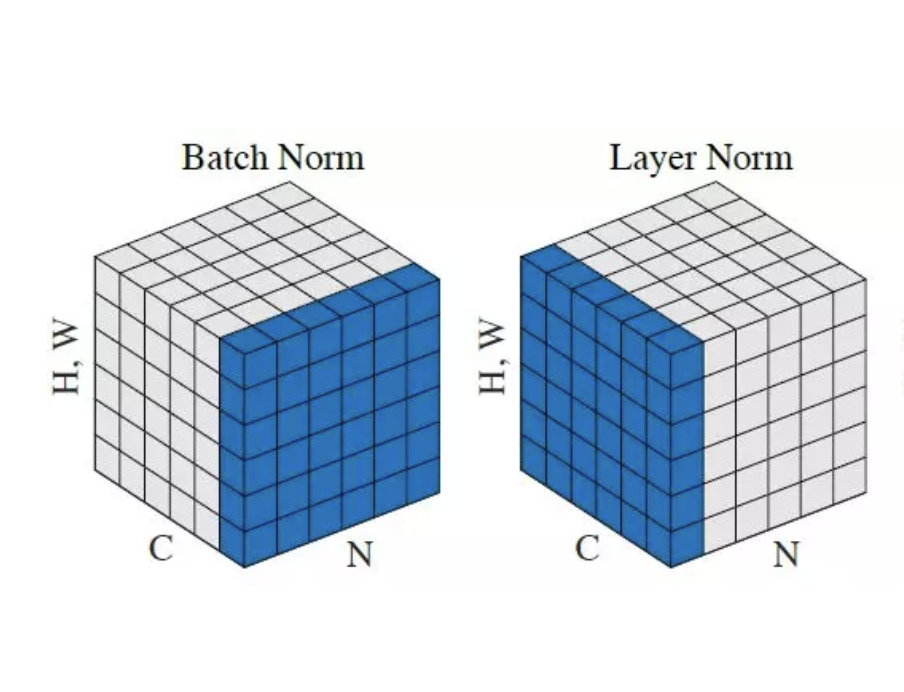


layer normalization을 잔여 블록 사이에 적용하는 것이 아니라 잔여 블록의 첫 번째 레이어로 적용하는 것이 이 아이디어입니다. 이렇게 레이어를 재구성하면 더 나은 gradient 전달을 지원하고 학습의 워밍업 단계가 필요하지 않습니다.
표준 Post-LN 버전과 Pre-LN 버전의 차이점을 시각화한 그림은 아래와 같습니다.

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/11-vision-transformer/pre_layer_norm.svg" width="400px"></center>


In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0] #query, attention weight
        x = x + self.linear(self.layer_norm_2(x))
        return x

이제 자체 비전 트랜스포머를 구축하기 위한 모든 모듈이 준비되었습니다.
트랜스포머 인코더 외에도 다음 모듈이 필요합니다:

- 입력 패치를 더 큰 크기의 특성 벡터로 매핑하는 **linear projection layer**는 각 $M \times M$ 패치를 독립적으로 입력으로 받아들이는 간단한 선형 레이어입니다.
- 입력 시퀀스에 추가되는 **Classification token**은 분류 예측을 결정하기 위해 분류 토큰의 출력 특성 벡터(CLS 토큰)로 사용합니다.
- 트랜스포머가 처리하기 전에 토큰에 추가되는 **positional encoding**은 위치에 의존적인 정보를 학습하고, 세트를 시퀀스로 변환하는 데 필요합니다. 일반적으로 고정된 해상도로 작업하기 때문에, 사인 및 코사인 함수의 패턴 대신 위치 인코딩을 학습합니다.
- CLS 토큰의 출력 특성 벡터를 받아 분류 예측으로 매핑하는 **MLP head**는 일반적으로 작은 전방 신경망이나 단일 선형 레이어로 구현됩니다.

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

마지막으로, 평소처럼 모든 것을 파이토치 라이트닝 모듈에 넣으면 됩니다. 최적화 도구로 torch.optim.AdamW를 사용하는데, 이는 가중치 감쇠가 수정된 Adam입니다. Pre-LN Transformer 버전을 사용하기 때문에 더 이상 학습 속도 워밍업 단계를 사용할 필요가 없습니다. 대신 이전 이미지 분류 튜토리얼의 CNN과 동일한 학습 속도 스케줄러를 사용합니다.

In [ ]:
class ViT(L.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

## Experiments

일반적으로 비전 트랜스포머는 ImageNet과 같은 대규모 이미지 분류 벤치마크에 적용되어 그 잠재력을 최대한 활용합니다. 하지만 여기서는 한 걸음 물러나서 CIFAR10과 같은 고전적인 소규모 벤치마크에서도 비전 트랜스포머가 성공할 수 있을까요? 이를 알아보기 위해 CIFAR10 데이터 세트에 대해 처음부터 Vision Transformer를 훈련해 보겠습니다.
먼저 파이토치 라이트닝 모듈을 위한 훈련 함수를 만들어 보겠습니다.
이 함수는 위에서 다운로드한 사전 훈련된 모델을 로드합니다.

In [ ]:
def train_model(**kwargs):
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
        accelerator="auto",
        devices=1,
        max_epochs=180,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        # Automatically loads the model with the saved hyperparameters
        model = ViT.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything(42)  # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

이제 모델 학습을 시작할 수 있습니다. 구현에서 볼 수 있듯이 몇 가지 하이퍼파라미터를 선택해야 합니다. 이 노트북을 만들 때 하이퍼파라미터에 대해 작은 그리드 검색을 수행하여 아래 셀에 최상의 하이퍼파라미터를 나열했습니다. 그럼에도 불구하고 각 하이퍼파라미터가 미치는 영향과 그 값을 선택할 때 어떤 직관이 필요한지 논의할 가치가 있습니다.

먼저 패치 크기를 고려해 봅시다. 패치를 작게 만들수록 트랜스포머에 대한 입력 시퀀스가 길어집니다. 일반적으로 트랜스포머가 더 복잡한 함수를 모델링할 수 있지만, attention 계층에서 제곱뱅의 메모리 사용으로 인해 계산 시간이 더 오래 걸립니다. 또한 패치가 작으면 트랜스포머가 어떤 패치가 가까이 있고 어떤 패치가 멀리 떨어져 있는지 학습해야 하므로 작업이 더 어려워질 수 있습니다. 패치 크기가 2, 4, 8인 경우 입력 시퀀스 길이가 각각 256, 64, 16이 되는 실험을 진행했습니다. 4가 가장 좋은 성능을 제공하므로 아래에서 4를 선택했습니다.

다음으로, 임베딩 및 hidden 차원은 MLP와 마찬가지로 트랜스포머에 비슷한 영향을 미칩니다. 크기가 클수록 모델이 더 복잡해지고 훈련하는 데 더 오랜 시간이 걸립니다. 하지만 트랜스포머에서는 고려해야 할 측면이 하나 더 있는데, 바로 다중 헤드 어텐션 계층의 쿼리 키 크기입니다. 각 키의 특징 차원은 embed_dim/num_heads입니다. 입력 시퀀스 길이가 64라는 점을 고려할 때 키 벡터의 최소 합리적인 크기는 16 또는 32입니다. 차원이 낮으면 가능한 attention maps를 너무 많이 제한할 수 있습니다. 트랜스포머에는 8개 이상의 헤드가 필요하지 않으므로 256의 임베딩 차원을 선택했습니다. 피드포워드 네트워크의 숨겨진 차원은 일반적으로 임베딩 차원보다 2~4배 더 크므로 512를 선택했습니다.

마지막으로, 트랜스포머의 학습 속도는 일반적으로 상대적으로 작으며, 논문에서 일반적으로 사용하는 값은 3e-5입니다. 그러나 우리는 더 작은 데이터 세트로 작업하고 잠재적으로 더 쉬운 작업을 수행하기 때문에 학습 속도를 문제없이 3e-4로 높일 수 있다는 것을 발견했습니다. 과적합을 줄이기 위해 0.2의 드롭아웃 값을 사용합니다. 또한 훈련 중에 작은 이미지 증강을 정규화로 사용한다는 점을 기억하세요.

아래 값을 변경하여 하이퍼파라미터를 직접 탐색해 보세요. 일반적으로 비전 트랜스포머는 CIFAR10 데이터 세트의 하이퍼파라미터 선택에 너무 민감하지 않은 것으로 나타났습니다.

In [ ]:
model, results = train_model(
    model_kwargs={
        "embed_dim": 256,
        "hidden_dim": 512,
        "num_heads": 8,
        "num_layers": 6,
        "patch_size": 4,
        "num_channels": 3,
        "num_patches": 64,
        "num_classes": 10,
        "dropout": 0.2,
    },
    lr=3e-4,
)
print("ViT results", results)

비전 트랜스포머는 약 75%의 검증 및 테스트 성능을 달성했습니다.
이에 비해 다른 CNN들의 아키텍처는 약 90%의 분류 성능을 얻었습니다.
이는 상당한 격차로, 비전 트랜스포머가 잠재적인 사전 학습을 통해 이미지넷에서 강력한 성능을 발휘하지만, 처음부터 학습할 경우 CIFAR10의 단순 CNN에 근접할 수 없음을 보여줍니다.
CNN과 트랜스포머의 차이는 훈련 곡선에서 잘 관찰할 수 있습니다.
아래 텐서보드에서 이를 살펴보겠습니다:

In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir "/content/saved_models"

<center><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/11-vision-transformer/tensorboard_screenshot.png" width="100%"/></center>

텐서보드는 비전 트랜스포머와 CIFAR10에서 훈련된 ResNet을 비교합니다. 학습 손실을 살펴보면 첫 번째 반복에서 ResNet이 훨씬 더 빠르게 학습하는 것을 알 수 있습니다. 학습 속도가 초기 학습 속도에 영향을 미칠 수 있지만, 검증 정확도에서도 동일한 추세를 확인할 수 있습니다. ResNet은 단 5회(2000회 반복) 만에 비전 트랜스포머의 최고 성능을 달성합니다. 또한 ResNet의 학습 손실과 검증 정확도는 비슷한 추세를 보이는 반면, 비전 트랜스포머의 검증 성능은 10,000회 반복 후 약간의 변화만 있는 반면 학습 손실은 계속 감소하기 시작합니다. 하지만 비전 트랜스포머는 훈련 세트에서 100%에 가까운 정확도를 달성할 수 있습니다.

이러한 관찰된 모든 현상은 앞서 살펴본 inductive bias이라는 개념으로 설명할 수 있습니다. 컨볼루션 신경망은 이미지가 translation invariant이라는 가정 하에 설계되었습니다. 따라서 이미지 전체에 공유된는 컨볼루션 필터를 적용합니다. 또한 CNN 아키텍처는 이미지에 거리 개념을 적용해 서로 가까운 두 픽셀은 멀리 떨어진 두 픽셀보다 더 관련성이 높다고 가정합니다. 따라서 로컬 패턴은 분류 예측을 수행할 때까지 더 큰 패턴으로 결합됩니다. 이러한 모든 측면은 CNN의 inductive bias입니다. 반면 비전 트랜스포머는 어떤 두 픽셀이 서로 가깝고 어떤 픽셀이 멀리 떨어져 있는지 알지 못합니다. 비전 트랜스포머는 분류 작업의 학습 신호로부터만 이 정보를 학습해야 합니다. 이러한 정보는 보이지 않는 테스트 데이터 세트로 일반화하는 데 매우 중요하기 때문에 학습 데이터가 작을 때는 큰 단점이 됩니다. 데이터 세트가 충분히 크거나 사전 훈련이 잘 되어 있다면, 트랜스포머는 Inductive bias 없이도 이러한 정보를 학습할 수 있으며, 대신 CNN보다 더 유연합니다. 특히 로컬 패턴 간의 장거리 관계는 CNN에서 처리하기 어려울 수 있지만, 트랜스포머에서는 모든 패치가 하나의 거리를 갖습니다. 그렇기 때문에 비전 트랜스포머는 이미지넷과 같은 대규모 데이터 세트에서는 매우 강력하지만 CIFAR10과 같은 소규모 데이터 세트에 적용하면 성능이 크게 저하됩니다.

## Conclusion

이 튜토리얼에서는 자체 비전 트랜스포머를 처음부터 구현하여 이미지 분류 작업에 적용했습니다. 비전 트랜스포머는 이미지를 일련의 작은 패치로 분할하고 이를 표준 트랜스포머 인코더에 입력으로 사용하는 방식으로 작동합니다. 비전 트랜스포머는 ImageNet과 같은 대규모 이미지 인식 벤치마크에서는 뛰어난 결과를 얻었지만, CIFAR10과 같은 소규모 데이터 세트에서 처음부터 훈련할 때는 성능이 상당히 떨어졌습니다. 그 이유는 CNN과 달리 트랜스포머에는 Translation invariant와 feature hierarchy(즉, 큰 패턴이 여러 개의 작은 패턴으로 구성됨)이라는 귀납적 편향이 없기 때문입니다.
그러나 이러한 측면은 충분한 데이터가 제공되거나 모델이 다른 대규모 작업에 대해 사전 학습된 경우 학습할 수 있습니다.
비전 트랜스포머가 2020년 말에 제안되었다는 점을 고려하면 컴퓨터 비전용 트랜스포머에는 앞으로 더 많은 기능이 추가될 것으로 보입니다.


### References

Dosovitskiy, Alexey, et al.
"An image is worth 16x16 words: Transformers for image recognition at scale."
International Conference on Representation Learning (2021).
[link](https://arxiv.org/pdf/2010.11929.pdf)

Chen, Xiangning, et al.
"When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations."
arXiv preprint arXiv:2106.01548 (2021).
[link](https://arxiv.org/abs/2106.01548)

Tolstikhin, Ilya, et al.
"MLP-mixer: An all-MLP Architecture for Vision."
arXiv preprint arXiv:2105.01601 (2021).
[link](https://arxiv.org/abs/2105.01601)

Xiong, Ruibin, et al.
"On layer normalization in the transformer architecture."
International Conference on Machine Learning.
PMLR, 2020.
[link](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)